# Electricity Consumption Analytics 

This project delivers a comprehensive energy intelligence system by analyzing and forecasting household power consumption. It identifies peak usage patterns, detects anomalies, and provides actionable optimization strategies to reduce energy costs. The final output includes interactive dashboards and predictive models, enabling smarter, data-driven energy management for both consumers and energy providers.

- Dataset: household_power_consumption.txt
- Domain: Energy / Smart Home
- Tools: SQL, Power BI, DAX, KPI & Dashboards, Python, Machine Learning & Time Series.

------

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('household_power_consumption.txt', sep=';', na_values='?', low_memory=False)

# Combine Date and Time into Datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('Datetime', inplace=True) # Set Datetime as index

# Convert rest of the columns to numeric
for col in df.columns.difference(['Date', 'Time']):
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop old Date and Time columns
df.drop(['Date', 'Time'], axis=1, inplace=True)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


---------
# Phase 4: Demand Forecasting
Summary: Predict future needs for grid planning and smart scheduling

## Q1. Plot moving average for 7-day consumption.

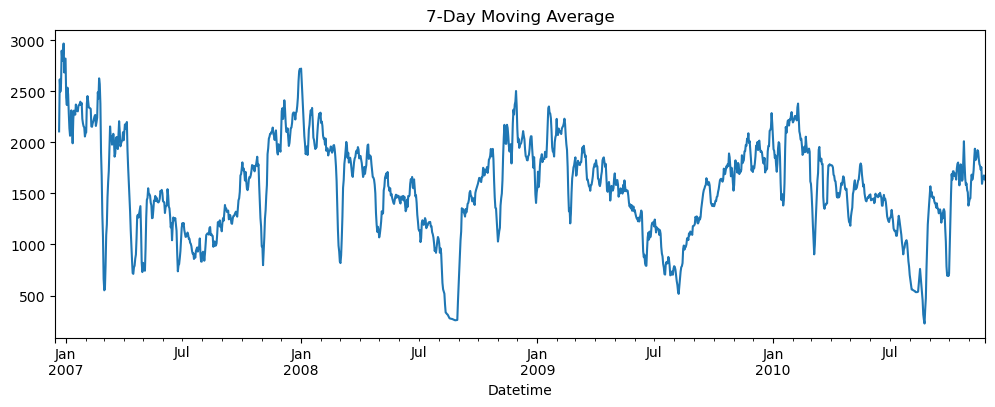

In [6]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12,4))
ma7 = df['Global_active_power'].resample('D').sum().rolling(7).mean()
ma7.plot(title='7-Day Moving Average')
plt.show()

## Q2. Find day-over-day change.

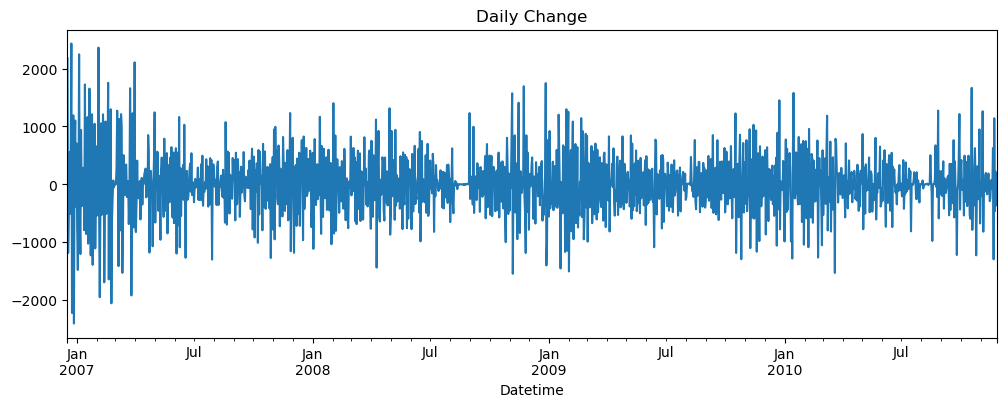

In [8]:
plt.figure(figsize=(12,4))
diff = df['Global_active_power'].resample('D').sum().diff()
diff.plot(title='Daily Change')
plt.show()

## Q3. Which day of week shows highest average demand?

In [9]:
import calendar
dow = df['Global_active_power'].groupby(df.index.dayofweek).mean()
print(f"Peak day: {calendar.day_name[dow.idxmax()]}")

Peak day: Saturday


## Q4. Analyze average electricity consumption per hour of day.

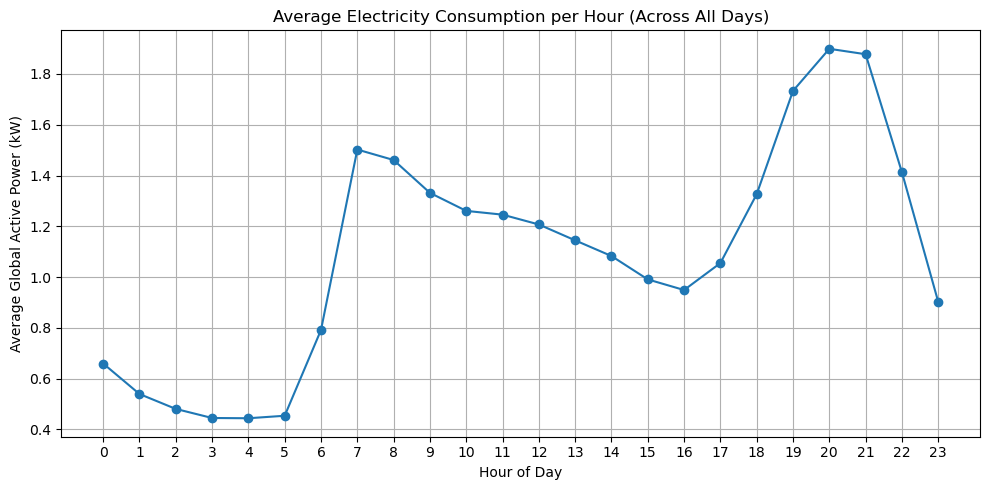

In [16]:
import matplotlib.pyplot as plt

# Group by hour of day and calculate average Global Active Power
hourly_avg = df.groupby(df.index.hour)['Global_active_power'].mean()

plt.figure(figsize=(10, 5))
hourly_avg.plot(kind='line', marker='o')
plt.title('Average Electricity Consumption per Hour (Across All Days)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Global Active Power (kW)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

## Q5. Demand Forecasting  with Simple Linear Regression

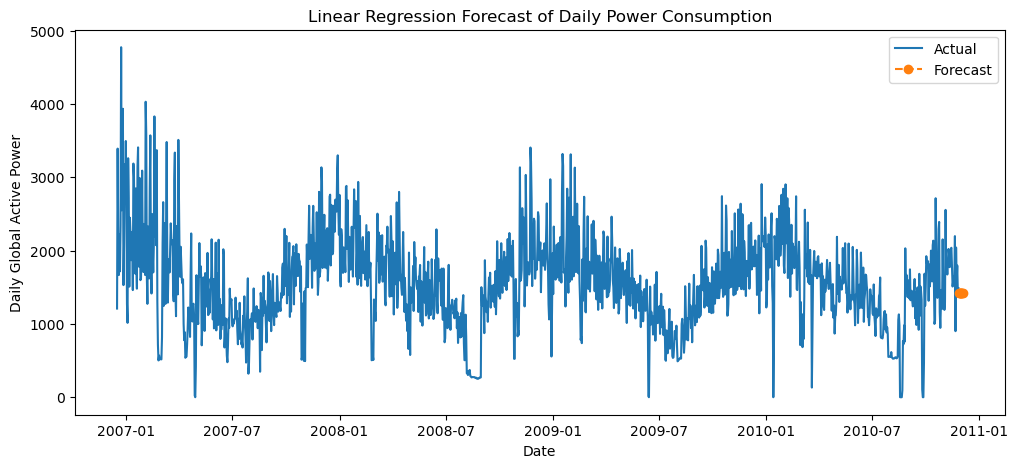

In [21]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Aggregate daily data
daily = df['Global_active_power'].resample('D').sum().reset_index()

# Create integer time variable
daily['day_num'] = np.arange(len(daily))

# Train linear regression model
model = LinearRegression()
model.fit(daily[['day_num']], daily['Global_active_power'])

# Forecast next 7 days
future_days = np.arange(len(daily), len(daily) + 7).reshape(-1, 1)
forecast = model.predict(future_days)

# Create datetime index for forecast
future_dates = pd.date_range(start=daily['Datetime'].iloc[-1] + pd.Timedelta(days=1), periods=7)

# Plot actual and forecast
plt.figure(figsize=(12,5))
plt.plot(daily['Datetime'], daily['Global_active_power'], label='Actual')
plt.plot(future_dates, forecast, label='Forecast', linestyle='--', marker='o')
plt.xlabel('Date')
plt.ylabel('Daily Global Active Power')
plt.title('Linear Regression Forecast of Daily Power Consumption')
plt.legend()
plt.show()

#### Interpretation:
- The linear regression model projects a moderate forecast value, aligned with the historical average but fails to capture the seasonal variation clearly visible in past trends.
- The forecast point appears relatively flat compared to recent fluctuations, suggesting the model captures long-term trend but misses short-term seasonality and spikes.
- This type of model is simple and fast, but better suited for datasets with steady trends, not cyclic energy patterns.

## Q6. Can deep learning models like LSTM predict future electricity consumption accurately? 

In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

data = df['Global_active_power'].resample('D').sum().dropna()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values.reshape(-1,1))

X, y = [], []
for i in range(30, len(scaled_data)):
    X.append(scaled_data[i-30:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [11]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(30, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, verbose=1)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(y_test)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print("LSTM RMSE:", rmse)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0679
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0113
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0101
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0097
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0094
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0100
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0095
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0103
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0101
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0094
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0096
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0099
Epoch 13/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0090
Epoch 14/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0088
Epoch 15/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0093
Epoc

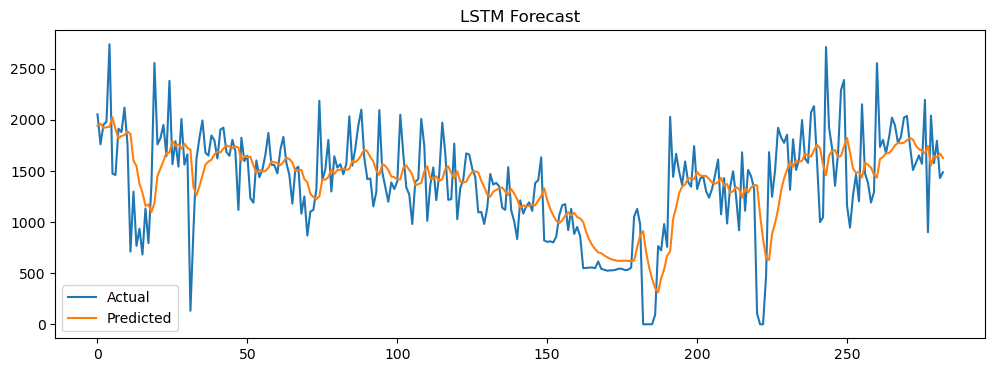

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title("LSTM Forecast")
plt.legend()
plt.show()

#### Interpretation:
- Predicted vs actual line charts should overlap; if not, the LSTM might be overfitting or struggling with irregular patterns.
- LSTM was tested for deep pattern recognition. If performance is weak, it's likely due to limited data or need for more epochs/tuning.